In [1]:
# AMP decoder for signal recovery in compressed sensing.
# CS model: y = Ax + noise
# Goal: recover x given y and A
#
# Compare the performance of the AMP with the Onsager term computed using either
# 1) the empirical average of the derivative of the denoiser (eta function), or
# 2) the expectation of the derivative, which can be rewritten using Stein's 
#    lemma so that it doesn't require an analytical form for the derivative,
#    and it can be approximated using Monte Carlo sampling.
#
# Only consider signals with iid entries drawm from the 3-point distribution:
# entries equal to 0 with probability (1-eps) and equal to either 
# +1 or -1 with probability eps/2 each.
#
# Copyright (c) 2021 Kuan Hsieh

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from amp4cs import initialise_CS, opt_tuning_param, soft_thresh, se

# AMP comparison

In [8]:
N     = 1000  # dimension of signal
M     = 500  # num of measurements
K     = 50   # num of non-zero coefficients
sigma = 0.1  # Noise standard deviation

delta    = M/N
eps      = K/N
alpha    = opt_tuning_param(eps) # Find optimal alpha
iter_max = 20 # Max num of iterations

y, A, x_init = initialise_CS(N, M, K, sigma, x_choice=0)

In [9]:
# Run AMP decoder with both soft-thresholding and MMSE denoiser
nsamples = N # Number of Monte Carlo samples used in approx. Onsager term

x1 = np.zeros_like(x_init) # Initial signal estimate
x2 = np.zeros_like(x_init)
z1 = y                     # Initial residual
z2 = y
mse1 = np.ones(iter_max)*np.mean(x_init**2) # Store empirical MSE across iterations
mse2 = np.ones(iter_max)*np.mean(x_init**2)

for t in range(iter_max-1):
    
    ### Original soft-threholding AMP ###
    
    # Estimate vector
    theta1 = alpha*np.sqrt(LA.norm(z1)**2/M) # alpha*tau (tau is std deviation)
    x1     = soft_thresh(x1 + np.dot(A.T,z1), theta1)
    
    # Calculate residual with the Onsager term
    b1 = LA.norm(x1,0)/M
    z1 = y - np.dot(A,x1) + b1*z1
    
    # Calculate MSE
    mse1[t+1] = np.mean((x1-x_init)**2)
    
    ### Soft-threholding AMP w/ approx. Onsager term ###
        
    # Estimate vector
    tau    = np.sqrt(LA.norm(z2)**2/M)
    theta2 = alpha * tau
    x2     = soft_thresh(x2 + np.dot(A.T,z2), theta2)
    
    # Calculate residual with the APPROX. Onsager term
    X = np.random.choice([-1,0,1], nsamples, p=[eps/2, 1-eps, eps/2])
    G = tau * np.random.randn(nsamples) # noise
    b2 = (N/M) * (1/tau**2) * np.mean(soft_thresh(X+G,theta2) * G)
    z2 = y - np.dot(A,x2) + b2*z2
    
    # Calculate MSE
    mse2[t+1] = np.mean((x2-x_init)**2)

In [10]:
# State evolution, tau in SE is a variance not standard deviation
nsamples = 1000000
psi,_ = se(eps, delta, sigma, iter_max, nsamples)

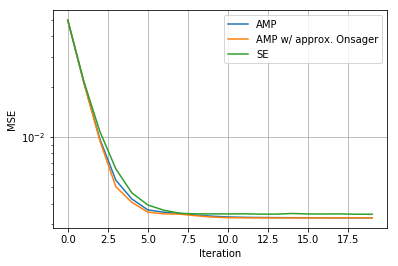

In [11]:
plt.plot(mse1, label='AMP')
plt.plot(mse2, label='AMP w/ approx. Onsager')
plt.plot(psi, label='SE')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.grid()
plt.legend()

Text(0.5, 1.0, 'AMP w/ approx. Onsager')

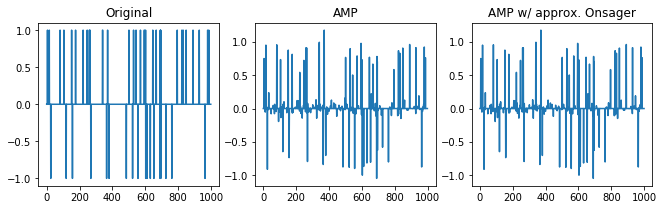

In [12]:
# Plot recovered signal from compressed sensing measurements
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.plot(x_init)
plt.title('Original')
plt.subplot(132)
plt.plot(x1)
plt.title('AMP')
plt.subplot(133)
plt.plot(x2)
plt.title('AMP w/ approx. Onsager')

# Testing Onsager approx. method

In [ ]:
# Using Stein's lemma, we evaluate E{eta'(X + tau*Z)} in the Onsager term 
# using E{eta(X+tau*Z) * tau*Z}/tau^2, where X is a random variable drawn 
# according to the signal distribution and Z is a standard Gaussian.
#
# We also know that if eta(.) is the conditional expectation (MMSE) estimator,
# then E{eta(X+tau*Z) * tau*Z} = E{[eta(X+tau*Z) - X]^2}, which is the 
# expected MMSE, which in turn is a quantity computed in state evolution.
# 
# Want to see how E{eta(X+tau*Z) * tau*Z} compared with 
# E{[eta(X+tau*Z) - X]^2} for eta(.) denoisers which are not MMSE estimators.
# 
# In the following I will consider the 3-point distribution with the 
# soft-thresholding denoiser.

In [13]:
nsamples = 1000000

eps_list = np.linspace(0.1, 1, 10)
tau_list = np.linspace(0.1, 1.2, 10)

psi1 = np.zeros((len(eps_list), len(tau_list)))
psi2 = np.zeros((len(eps_list), len(tau_list)))

for i, eps in enumerate(eps_list):
    
    alpha  = opt_tuning_param(eps) # Find optimal alpha
    
    for j, tau in enumerate(tau_list):
        
        theta = alpha * tau
        X = np.random.choice([-1,0,1], nsamples, p=[eps/2, 1-eps, eps/2])
        G = tau * np.random.randn(nsamples) # noise

        psi1[i,j] = np.mean(soft_thresh(X+G, theta) * G)        
        psi2[i,j] = np.mean((soft_thresh(X+G,theta) - X)**2)

Text(0.5, 0, '$\\tau$')

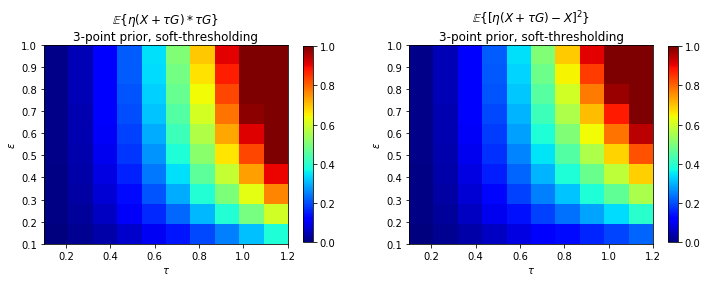

In [17]:
plt.figure(figsize=(12,6))

figextent = [tau_list[0], tau_list[-1], eps_list[0] , eps_list[-1]]

plt.subplot(121)
plt.imshow(psi1, cmap='jet', vmin=0, vmax=1, extent=figextent, interpolation='none', origin='lower')
plt.title(r'$\mathbb{E}\{\eta(X+\tau G) * \tau G\}$' +'\n'+'3-point prior, soft-thresholding')
plt.colorbar(shrink=0.6)
plt.ylabel(r'$\epsilon$')
plt.xlabel(r'$\tau$')

plt.subplot(122)
plt.imshow(psi2, cmap='jet', vmin=0, vmax=1, extent=figextent, interpolation='none', origin='lower')
plt.title(r'$\mathbb{E}\{[\eta(X+\tau G) - X]^2\}$' +'\n'+'3-point prior, soft-thresholding')
plt.colorbar(shrink=0.6)
plt.ylabel(r'$\epsilon$')
plt.xlabel(r'$\tau$')